<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/Danling/Danling_390_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## prophet single regressor

In [1]:
# libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
import prophet
import time as time
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train_final.csv', parse_dates = ['date'], index_col = ['date'])
test = pd.read_csv('test_final.csv', parse_dates = ['date'], index_col = ['date'])

In [3]:
train_sel_sig_prophet = train[['location_key_x', 'new_confirmed']]
test_sel_sig_prophet = test[['location_key_x', 'new_confirmed']]

We have a lot of different locations, let's play with US_AK first.

In [4]:
# try the model with one location
AK_train = train_sel_sig_prophet.loc[train_sel_sig_prophet.location_key_x == 'US_AK','new_confirmed']
AK_test = test_sel_sig_prophet.loc[test_sel_sig_prophet.location_key_x == 'US_AK','new_confirmed']

In [5]:
AK_train = AK_train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
AK_test = AK_test.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})

In [6]:
# fit a prophet model
model_AK = prophet.Prophet().fit(AK_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6zv7oyxs/_mw_0gxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6zv7oyxs/a9j229zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75608', 'data', 'file=/tmp/tmp6zv7oyxs/_mw_0gxz.json', 'init=/tmp/tmp6zv7oyxs/a9j229zq.json', 'output', 'file=/tmp/tmp6zv7oyxs/prophet_model4t_kya4e/prophet_model-20231105211523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:15:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [7]:
AK_train_predict = model_AK.predict(AK_train)
AK_train_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-80.447137,-312.709685,205.525032,-80.447137,-80.447137,32.763550,32.763550,32.763550,32.763550,32.763550,32.763550,0.0,0.0,0.0,-47.683587
1,2020-01-23,-79.316639,-323.448596,215.160925,-79.316639,-79.316639,29.980701,29.980701,29.980701,29.980701,29.980701,29.980701,0.0,0.0,0.0,-49.335938
2,2020-01-24,-78.186141,-307.113273,189.265888,-78.186141,-78.186141,13.257268,13.257268,13.257268,13.257268,13.257268,13.257268,0.0,0.0,0.0,-64.928872
3,2020-01-25,-77.055642,-344.069045,175.977680,-77.055642,-77.055642,-8.398171,-8.398171,-8.398171,-8.398171,-8.398171,-8.398171,0.0,0.0,0.0,-85.453813
4,2020-01-26,-75.925144,-384.728955,121.525585,-75.925144,-75.925144,-65.192092,-65.192092,-65.192092,-65.192092,-65.192092,-65.192092,0.0,0.0,0.0,-141.117236


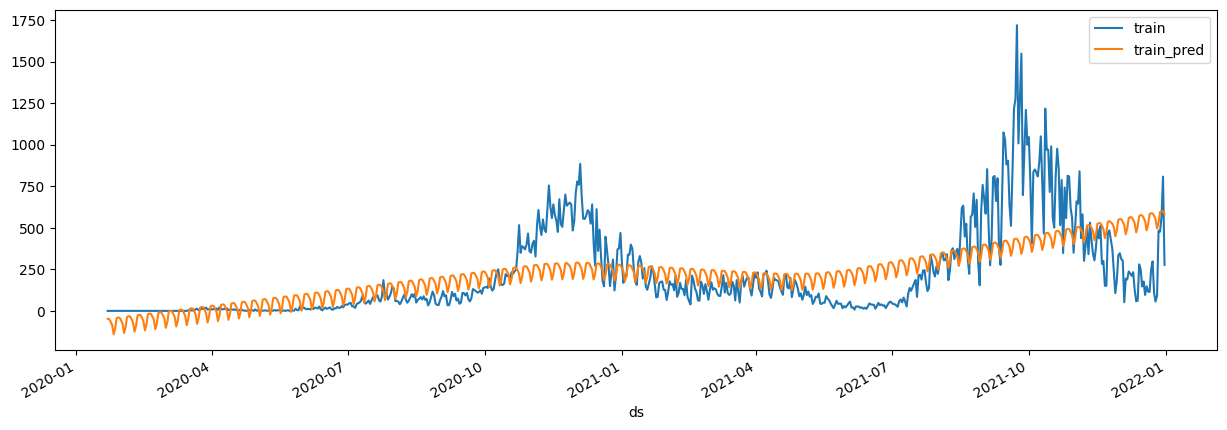

In [8]:
# make the date the index column for y_train and y_train_predict
AK_train_predict_y = AK_train_predict[['ds','yhat']].set_index('ds')
AK_train_date_index = AK_train.set_index('ds')
pd.concat([AK_train_date_index,AK_train_predict_y], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

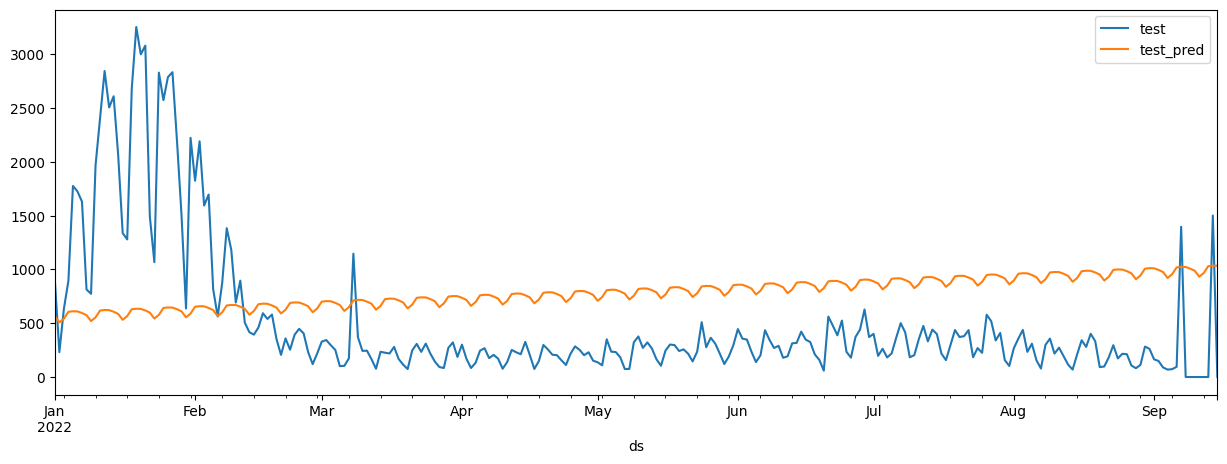

In [9]:
# let's predict the testing data
AK_test_predict = model_AK.predict(AK_test)
AK_test_predict_y = AK_test_predict[['ds','yhat']].set_index('ds')
AK_test_date_index = AK_test.set_index('ds')
pd.concat([AK_test_date_index,AK_test_predict_y], axis=1).plot(figsize=(15,5))
plt.legend(['test', 'test_pred'])

It seems like seasonal patterns can be depicted by the prophet model, but it is not good at finding "outliers" in the target variables

In [10]:
print('The RMSE of the training data is ', mean_squared_error(AK_train_date_index, AK_train_predict_y, squared=False))
print('The RMSE of the testing data is ', mean_squared_error(AK_test_date_index, AK_test_predict_y, squared=False))

The RMSE of the training data is  203.7459727125017
The RMSE of the testing data is  775.8791216251927


Not as good as ARIMA. Let's try to apply the model to all locations.

In [93]:
# making a pred_train and pred_test dataset
train_pred = train_sel_sig_prophet.copy()
train_pred.new_confirmed = None
train_pred.columns = ['location_key_x','predicted_new_confirmed']
train_pred.reset_index(inplace = True)
train_pred['date'] = pd.to_datetime(train_pred['date'])
#train_pred.rename(columns={'date':'ds', 'new_confirmed':'y'}, inplace = True)

test_pred = test_sel_sig_prophet.copy()
test_pred.new_confirmed = None
test_pred.columns = ['location_key_x','predicted_new_confirmed']
test_pred.reset_index(inplace = True)
#test_pred.rename(columns={'date':'ds', 'new_confirmed':'y'},  inplace = True)

In [94]:
start_time = time.time()

loc_list = list(train_sel_sig_prophet.location_key_x.unique())

for loc in loc_list:
  # initialize the dataset
  train_interest = train_sel_sig_prophet.loc[train_sel_sig_prophet.location_key_x == loc, 'new_confirmed'] # select the rows in the training data
  test_interest = test_sel_sig_prophet.loc[test_sel_sig_prophet.location_key_x == loc, 'new_confirmed'] # select the rows in the testing data
  train_interest = train_interest.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
  test_interest = test_interest.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
  # fit the model on the train dataset
  model = prophet.Prophet().fit(train_interest)
  pred_for_train = model.predict(train_interest)
  for date in pred_for_train.ds:
    train_pred.loc[(train_pred.location_key_x == loc) & (train_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_train.loc[pred_for_train.ds == date, 'yhat'])
  # predict test dataset
  pred_for_test = model.predict(test_interest)
  for date in pred_for_test.ds:
    test_pred.loc[(test_pred.location_key_x == loc) & (test_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_test.loc[pred_for_test.ds == date, 'yhat'])

print("Time taken = ", round((time.time()-start_time)/60), " minutes")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4gx0d_x2/9vdkqlkg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4gx0d_x2/xc629mwq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77273', 'data', 'file=/tmp/tmp4gx0d_x2/9vdkqlkg.json', 'init=/tmp/tmp4gx0d_x2/xc629mwq.json', 'output', 'file=/tmp/tmp4gx0d_x2/prophet_model7f0nivgd/prophet_model-20231105213322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:33:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Time taken =  6  minutes


In [95]:
train_pred

,date,location_key_x,predicted_new_confirmed
0,2020-01-22,US_AK,-47.895308
1,2020-01-23,US_AK,-49.54486
2,2020-01-24,US_AK,-65.158438
3,2020-01-25,US_AK,-85.679455
4,2020-01-26,US_AK,-141.370363
...,...,...,...
69908,2021-12-27,AU_WA,0.496434
69909,2021-12-28,AU_WA,0.626782
69910,2021-12-29,AU_WA,0.667524
69911,2021-12-30,AU_WA,0.475852


In [96]:
test_pred

,date,location_key_x,predicted_new_confirmed
0,2022-01-01,US_AK,563.240562
1,2022-01-02,US_AK,508.104373
2,2022-01-03,US_AK,542.825824
3,2022-01-04,US_AK,606.45464
4,2022-01-05,US_AK,611.155427
...,...,...,...
26217,2022-09-14,AU_WA,0.16099
26218,2022-09-15,AU_WA,-0.030681
26219,2022-09-16,AU_WA,-0.111373
26220,2022-09-23,AU_WA,-0.125063


In [97]:
print("the rmse on the training data is ", mean_squared_error(train.new_confirmed, train_pred.predicted_new_confirmed, squared = False))
print("the rmse on the testing data is ", mean_squared_error(test.new_confirmed, test_pred.predicted_new_confirmed, squared = False))

the rmse on the training data is  1777.2894315932667
the rmse on the testing data is  7757.199441083177


This model works is much less overfitting than ARIMA.

## prophet_multiple_regressors

In [139]:
train = pd.read_csv('train_final.csv', parse_dates = ['date'])
test = pd.read_csv('test_final.csv', parse_dates = ['date'])

It turns out that Prophet has built-in holiday functions for multiple countries.

In [107]:
print(train.country_code.unique())

['US' 'LU' 'IE' 'NO' 'CH' 'SG' 'QA' 'IS' 'DK' 'AU']


In [130]:
from prophet.make_holidays import make_holidays_df

us_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='US')
us_holidays['country_code'] ='US'
lu_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='LU')
lu_holidays['country_code'] ='LU'
ie_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='IE')
ie_holidays['country_code'] ='IE'
no_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='NO')
no_holidays['country_code'] = 'NO'
ch_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='CH')
ch_holidays['country_code'] = 'CH'
sg_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='SG')
sg_holidays['country_code'] = 'SG'
# qa_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='QA') Qatar is not supported
is_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='IS')
is_holidays['country_code'] = 'IS'
dk_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='DK')
dk_holidays['country_code'] = 'DK'
au_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='AU')
au_holidays['country_code'] = 'AU'


In [134]:
holidays = pd.concat([us_holidays, lu_holidays, ie_holidays, no_holidays, ch_holidays, sg_holidays, is_holidays, dk_holidays, au_holidays])

In [135]:
holidays.head()

,ds,holiday,country_code
0,2020-01-20,Martin Luther King Jr. Day,US
1,2020-02-17,Washington's Birthday,US
2,2020-10-12,Columbus Day,US
3,2020-01-01,New Year's Day,US
4,2020-05-25,Memorial Day,US


In [137]:
# Honestly I don't really care if what holiday it is, since there are so many in different countries
# however, I want to know if a specific day is a holiday or not.

holidays.holiday = 1
holidays.tail()

,ds,holiday,country_code
23,2022-12-26,1,AU
24,2022-01-01,1,AU
25,2022-01-03,1,AU
26,2022-04-15,1,AU
27,2022-04-18,1,AU


In [147]:
train_with_holiday = train.merge(holidays, how = 'left', left_on = ['date', 'country_code'], right_on = ['ds', 'country_code'])
train_with_holiday['holiday'].fillna(0, inplace = True)
test_with_holiday = test.merge(holidays, how = 'left', left_on = ['date', 'country_code'], right_on = ['ds', 'country_code'])
test_with_holiday['holiday'].fillna(0, inplace = True)

In [164]:
# drop useless columns
train_multi_prophet = train_with_holiday.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'ds', 'country_code','new_confirmed_std1'])
test_multi_prophet = test_with_holiday.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'ds', 'country_code','new_confirmed_std1'])

In [165]:
train_multi_prophet.head()

,date,location_key_x,new_deceased,cumulative_deceased,population,population_male,population_female,latitude,longitude,area_sq_km,...,new_confirmed_min7,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,holiday
0,2020-01-22,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,2,1,1,2020,22,22,4,Winter,0.0
1,2020-01-23,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,3,1,1,2020,23,23,4,Winter,0.0
2,2020-01-24,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,4,1,1,2020,24,24,4,Winter,0.0
3,2020-01-25,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,5,1,1,2020,25,25,4,Winter,0.0
4,2020-01-26,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,6,1,1,2020,26,26,4,Winter,0.0


In [166]:
# label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder2 = LabelEncoder() # for season

# day of the week -- turns out there is a day_of_week column that has already been encoded
# however, Mon-Sun is from 0-6 and I want it to be 1-7
train_multi_prophet['day_of_week']= train_multi_prophet['day_of_week'] + 1
test_multi_prophet['day_of_week']= test_multi_prophet['day_of_week'] + 1
# season
train_multi_prophet['season'] = label_encoder2.fit_transform(train_multi_prophet['season'])
test_multi_prophet['season']= label_encoder2.transform(test_multi_prophet['season'])

Drop additional rows.

Since I am modeling based on reagion, I don't need any information that is constant within a region.

In [187]:
for col in train_multi_prophet.loc[:, train_multi_prophet.nunique() <= 103].columns:
  print(col)

location_key_x
population
population_male
population_female
latitude
longitude
area_sq_km
life_expectancy
aggregation_level
gdp_usd
gdp_per_capita_usd
AG.LND.AGRI.K2
AG.LND.AGRI.ZS
AG.LND.ARBL.HA
AG.LND.ARBL.HA.PC
AG.LND.ARBL.ZS
AG.LND.CROP.ZS
AG.LND.FRST.K2
AG.LND.FRST.ZS
AG.LND.TOTL.K2
AG.PRD.CROP.XD
AG.PRD.FOOD.XD
AG.PRD.LVSK.XD
AG.SRF.TOTL.K2
BX.KLT.DINV.CD.WD
EG.ELC.ACCS.RU.ZS
EG.ELC.ACCS.UR.ZS
EG.ELC.ACCS.ZS
EG.ELC.RNEW.ZS
EG.FEC.RNEW.ZS
EN.ATM.CO2E.GF.KT
EN.ATM.CO2E.GF.ZS
EN.ATM.CO2E.KT
EN.ATM.CO2E.LF.KT
EN.ATM.CO2E.LF.ZS
EN.ATM.CO2E.PC
EN.ATM.CO2E.SF.KT
EN.ATM.CO2E.SF.ZS
EN.ATM.PM25.MC.M3
EN.ATM.PM25.MC.T1.ZS
EN.ATM.PM25.MC.T2.ZS
EN.ATM.PM25.MC.T3.ZS
EN.ATM.PM25.MC.ZS
EN.BIR.THRD.NO
EN.FSH.THRD.NO
EN.HPT.THRD.NO
EN.MAM.THRD.NO
EN.POP.DNST
ER.FSH.CAPT.MT
ER.FSH.PROD.MT
ER.LND.PTLD.ZS
ER.PTD.TOTL.ZS
IP.JRN.ARTC.SC
IT.CEL.SETS
IT.CEL.SETS.P2
IT.MLT.MAIN
IT.MLT.MAIN.P2
IT.NET.BBND
IT.NET.BBND.P2
IT.NET.SECR
IT.NET.SECR.P6
IT.NET.USER.ZS
NV.IND.TOTL.CN
NV.IND.TOTL.ZS
NY.ADJ.AEDU.GN.

In [189]:
col_to_keep = ['location_key_x', 'day_of_week', 'quarter', 'month', 'year','dayofmonth','weekofyear','season','holiday']
addtional_col = train_multi_prophet.loc[:, train_multi_prophet.nunique() > 103].columns.to_list()
for col in addtional_col:
  col_to_keep.append(col)

In [190]:
train_prophet_sel = train_multi_prophet[col_to_keep]
test_prophet_sel = test_multi_prophet[col_to_keep]

In [192]:
# put zeros to missing lagging features
train_prophet_sel.fillna(0, inplace = True)
test_prophet_sel.fillna(0, inplace = True)

In [194]:
train_prophet_sel.head()

,location_key_x,day_of_week,quarter,month,year,dayofmonth,weekofyear,season,holiday,date,...,new_confirmed_lag7,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std3,new_confirmed_std7,new_confirmed_max3,new_confirmed_max7,new_confirmed_min3,new_confirmed_min7,dayofyear
0,US_AK,3,1,1,2020,22,4,3,0.0,2020-01-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22
1,US_AK,4,1,1,2020,23,4,3,0.0,2020-01-23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23
2,US_AK,5,1,1,2020,24,4,3,0.0,2020-01-24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
3,US_AK,6,1,1,2020,25,4,3,0.0,2020-01-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25
4,US_AK,7,1,1,2020,26,4,3,0.0,2020-01-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26


In [207]:
# try with the first state
train_AK_multi = train_prophet_sel.loc[train_prophet_sel.location_key_x == 'US_AK']
test_AK_multi = test_prophet_sel.loc[test_prophet_sel.location_key_x == 'US_AK']
train_AK_multi.drop(columns = 'location_key_x', inplace = True)
test_AK_multi.drop(columns = 'location_key_x', inplace = True)

In [220]:
model = prophet.Prophet()
for col in train_AK_multi.columns:
    if col not in ['date', 'new_confirmed']:
        model.add_regressor(col)
model=model.fit(train_AK_multi.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4gx0d_x2/3teatahy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4gx0d_x2/xdzzzwdw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25653', 'data', 'file=/tmp/tmp4gx0d_x2/3teatahy.json', 'init=/tmp/tmp4gx0d_x2/xdzzzwdw.json', 'output', 'file=/tmp/tmp4gx0d_x2/prophet_modelaufydffl/prophet_model-20231105222729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:27:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:27:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [222]:
train_pred_AK_multi=model.predict(train_AK_multi.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
train_pred_AK_multi.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cumulative_deceased,cumulative_deceased_lower,...,weekofyear,weekofyear_lower,weekofyear_upper,year,year_lower,year_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-01-22,64.592628,-56.487180,89.071344,64.592628,64.592628,-51.966228,-51.966228,-51.966228,12.071242,12.071242,...,9.495968,9.495968,9.495968,70.044184,70.044184,70.044184,0.0,0.0,0.0,12.626401
2020-01-23,65.002570,-81.910693,61.144045,65.002570,65.002570,-73.351904,-73.351904,-73.351904,12.071242,12.071242,...,9.495968,9.495968,9.495968,70.044184,70.044184,70.044184,0.0,0.0,0.0,-8.349335
2020-01-24,65.412511,-83.940697,68.156022,65.412511,65.412511,-77.693154,-77.693154,-77.693154,12.071242,12.071242,...,9.495968,9.495968,9.495968,70.044184,70.044184,70.044184,0.0,0.0,0.0,-12.280643
2020-01-25,65.822453,-88.352764,55.721351,65.822453,65.822453,-80.848852,-80.848852,-80.848852,12.071242,12.071242,...,9.495968,9.495968,9.495968,70.044184,70.044184,70.044184,0.0,0.0,0.0,-15.026399
2020-01-26,66.232394,-99.947693,39.119861,66.232394,66.232394,-96.242058,-96.242058,-96.242058,12.071242,12.071242,...,9.495968,9.495968,9.495968,70.044184,70.044184,70.044184,0.0,0.0,0.0,-30.009664


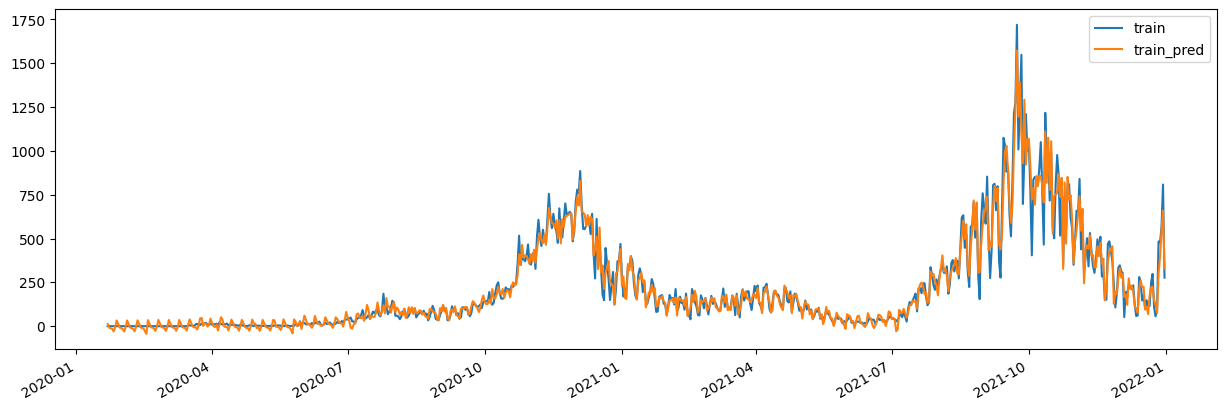

In [225]:
train_AK_multi.set_index('date', inplace = True)
pd.concat([train_AK_multi['new_confirmed'],train_pred_AK_multi['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

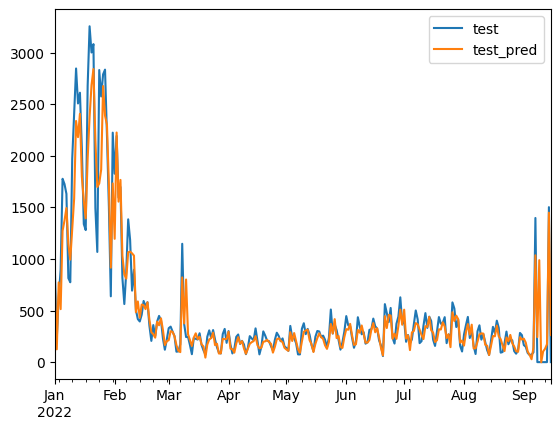

In [226]:
test_pred_AK_multi=model.predict(test_AK_multi.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
test_AK_multi.set_index('date', inplace = True)
pd.concat([test_AK_multi['new_confirmed'],test_pred_AK_multi['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

LOVE IT!!!!!! Let's check the RMSE.

In [227]:
print("the rmse on the training data is ", mean_squared_error(train_AK_multi.new_confirmed, train_pred_AK_multi.yhat, squared = False))
print("the rmse on the testing data is ", mean_squared_error(test_AK_multi.new_confirmed, test_pred_AK_multi.yhat, squared = False))

the rmse on the training data is  57.34347229895542
the rmse on the testing data is  199.8137832263485


Now code this for the whole dataset

In [228]:
train_prophet_sel

,location_key_x,day_of_week,quarter,month,year,dayofmonth,weekofyear,season,holiday,date,...,new_confirmed_lag7,new_confirmed_mean3,new_confirmed_mean7,new_confirmed_std3,new_confirmed_std7,new_confirmed_max3,new_confirmed_max7,new_confirmed_min3,new_confirmed_min7,dayofyear
0,US_AK,3,1,1,2020,22,4,3,0.0,2020-01-22,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,22
1,US_AK,4,1,1,2020,23,4,3,0.0,2020-01-23,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,23
2,US_AK,5,1,1,2020,24,4,3,0.0,2020-01-24,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,24
3,US_AK,6,1,1,2020,25,4,3,0.0,2020-01-25,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,25
4,US_AK,7,1,1,2020,26,4,3,0.0,2020-01-26,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69908,AU_WA,1,4,12,2021,27,52,2,1.0,2021-12-27,...,0.0,4.000000,2.857143,4.358899,2.911390,9.0,9.0,1.0,1.0,361
69909,AU_WA,2,4,12,2021,28,52,2,1.0,2021-12-28,...,1.0,2.000000,3.142857,1.000000,2.794553,3.0,9.0,1.0,1.0,362
69910,AU_WA,3,4,12,2021,29,52,2,0.0,2021-12-29,...,4.0,1.666667,2.571429,1.527525,2.992053,3.0,9.0,0.0,0.0,363
69911,AU_WA,4,4,12,2021,30,52,2,0.0,2021-12-30,...,2.0,2.666667,3.000000,2.516611,3.109126,5.0,9.0,0.0,0.0,364


In [230]:
# making a pred_train and pred_test dataset
train_pred = train_sel_sig_prophet.copy()
train_pred.new_confirmed = None
train_pred.columns = ['location_key_x','predicted_new_confirmed']
train_pred.reset_index(inplace = True)
train_pred['date'] = pd.to_datetime(train_pred['date'])

test_pred = test_sel_sig_prophet.copy()
test_pred.new_confirmed = None
test_pred.columns = ['location_key_x','predicted_new_confirmed']
test_pred.reset_index(inplace = True)

In [235]:
start_time = time.time()

loc_list = list(train_prophet_sel.location_key_x.unique())

for loc in loc_list:
  # initialize the dataset
  train_interest = train_prophet_sel.loc[train_prophet_sel.location_key_x == loc] # select the rows in the training data
  test_interest = test_prophet_sel.loc[test_prophet_sel.location_key_x == loc] # select the rows in the testing data
  # drop the location key
  train_interest.drop(columns = 'location_key_x', inplace = True)
  test_interest.drop(columns = 'location_key_x', inplace = True)
  # fit the model on the train dataset
  model = prophet.Prophet()
  for col in train_interest.columns:
    if col not in ['date', 'new_confirmed']:
      model.add_regressor(col)
  model=model.fit(train_interest.rename(columns={'date':'ds', 'new_confirmed':'y'}))
  # predict the training data
  # fit the model on the train dataset
  pred_for_train = model.predict(train_interest.rename(columns={'date':'ds', 'new_confirmed':'y'}))
  for date in pred_for_train.ds:
    train_pred.loc[(train_pred.location_key_x == loc) & (train_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_train.loc[pred_for_train.ds == date, 'yhat'])
  # predict test dataset
  pred_for_test = model.predict(test_interest.rename(columns={'date':'ds', 'new_confirmed':'y'}))
  for date in pred_for_test.ds:
    test_pred.loc[(test_pred.location_key_x == loc) & (test_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_test.loc[pred_for_test.ds == date, 'yhat'])

print("Time taken = ", round((time.time()-start_time)/60), " minutes")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4gx0d_x2/fh4oh7nb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4gx0d_x2/ipf_le8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24760', 'data', 'file=/tmp/tmp4gx0d_x2/fh4oh7nb.json', 'init=/tmp/tmp4gx0d_x2/ipf_le8h.json', 'output', 'file=/tmp/tmp4gx0d_x2/prophet_modelyc1mhhrf/prophet_model-20231105224905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Time taken =  7  minutes


In [236]:
train_pred

,date,location_key_x,predicted_new_confirmed
0,2020-01-22,US_AK,12.626401
1,2020-01-23,US_AK,-8.349335
2,2020-01-24,US_AK,-12.280643
3,2020-01-25,US_AK,-15.026399
4,2020-01-26,US_AK,-30.009664
...,...,...,...
69908,2021-12-27,AU_WA,6.310221
69909,2021-12-28,AU_WA,2.75706
69910,2021-12-29,AU_WA,0.300387
69911,2021-12-30,AU_WA,3.287686


In [237]:
test_pred

,date,location_key_x,predicted_new_confirmed
0,2022-01-01,US_AK,752.053467
1,2022-01-02,US_AK,124.191727
2,2022-01-03,US_AK,772.497128
3,2022-01-04,US_AK,513.506047
4,2022-01-05,US_AK,1272.642943
...,...,...,...
26217,2022-09-14,AU_WA,37.624738
26218,2022-09-15,AU_WA,-69.136848
26219,2022-09-16,AU_WA,-119.049817
26220,2022-09-23,AU_WA,-41.608347


In [238]:
print("the rmse on the training data is ", mean_squared_error(train.new_confirmed, train_pred.predicted_new_confirmed, squared = False))
print("the rmse on the testing data is ", mean_squared_error(test.new_confirmed, test_pred.predicted_new_confirmed, squared = False))

the rmse on the training data is  703.5020900887735
the rmse on the testing data is  3220.7931888002076


This is so far the best performing model on the testing data among 5 models I have attempted (LGBM, Arima and auto arima, single prophet and multiple prophet)